In [3]:
import pandas as pd
import os
import numpy as np

In [4]:
convertTable = dict()
convertTable['Zip Code'] = str
df = pd.read_csv ('Telco_customer_churn.csv', dtype = convertTable)
df['Total Charges'] = pd.to_numeric(df['Total Charges'] , errors='coerce')
df[df['Total Charges'].isnull()==True]
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.50,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30,Yes,1,89,5340,Competitor had better devices


### Missing Value 

In [5]:
# Calculate the percentage of missing values 
missing_values = df.isnull().sum()
missing_values_percentage = 100 * missing_values / len(df)
missing_values_table = pd.concat([missing_values, missing_values_percentage], axis=1)
missing_values_table = missing_values_table.rename(columns = {0 : 'Missing Values', 1 : '% of Missing Values'})
missing_values_table = missing_values_table[missing_values_table.iloc[:,0] != 0].sort_values('% of Missing Values', ascending=False).round(1)
missing_values_table

,Missing Values,% of Missing Values
Churn Reason,5174,73.5
Total Charges,11,0.2


In [6]:
# drop missing value
df = df.drop(['Churn Reason'], axis=1)
df.dropna(how = 'any', inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7032 non-null   object 
 1   Count              7032 non-null   int64  
 2   Country            7032 non-null   object 
 3   State              7032 non-null   object 
 4   City               7032 non-null   object 
 5   Zip Code           7032 non-null   object 
 6   Lat Long           7032 non-null   object 
 7   Latitude           7032 non-null   float64
 8   Longitude          7032 non-null   float64
 9   Gender             7032 non-null   object 
 10  Senior Citizen     7032 non-null   object 
 11  Partner            7032 non-null   object 
 12  Dependents         7032 non-null   object 
 13  Tenure Months      7032 non-null   int64  
 14  Phone Service      7032 non-null   object 
 15  Multiple Lines     7032 non-null   object 
 16  Internet Service   7032 

# Logistic Regression (Full Model)

## 1. Prepare Data for Logistic Regression

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import scale
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from numpy import mean
# from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE 
%matplotlib inline

In [58]:
df_logis = df[['Churn Value','Gender','Senior Citizen','Partner','Dependents','Tenure Months','Phone Service','Multiple Lines','Internet Service','Online Security','Online Backup','Device Protection','Tech Support','Streaming TV','Streaming Movies','Contract','Paperless Billing','Payment Method','Monthly Charges','Total Charges']]
df_logis.head()

,Churn Value,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges
0,1,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15
1,1,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65
2,1,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50
3,1,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05
4,1,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30


0    5163
1    1869
Name: Churn Value, dtype: int64


C:\Users\kornc\Documents\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Churn Value', ylabel='count'>

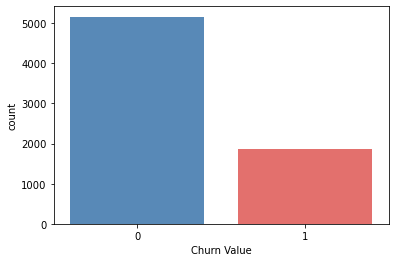

In [59]:
# check weight Churn Yes and No
churn_count = pd.value_counts(df_logis['Churn Value'])
print(churn_count)
sns.countplot(df_logis['Churn Value'], palette=['#488AC7',"#F75D59"])

In [60]:
# get dummy into dataframe
dummy_df_logis = pd.get_dummies(df_logis)
print(dummy_df_logis.columns)
dummy_df_logis.head()

Index(['Churn Value', 'Tenure Months', 'Monthly Charges', 'Total Charges',
       'Gender_Female', 'Gender_Male', 'Senior Citizen_No',
       'Senior Citizen_Yes', 'Partner_No', 'Partner_Yes', 'Dependents_No',
       'Dependents_Yes', 'Phone Service_No', 'Phone Service_Yes',
       'Multiple Lines_No', 'Multiple Lines_No phone service',
       'Multiple Lines_Yes', 'Internet Service_DSL',
       'Internet Service_Fiber optic', 'Internet Service_No',
       'Online Security_No', 'Online Security_No internet service',
       'Online Security_Yes', 'Online Backup_No',
       'Online Backup_No internet service', 'Online Backup_Yes',
       'Device Protection_No', 'Device Protection_No internet service',
       'Device Protection_Yes', 'Tech Support_No',
       'Tech Support_No internet service', 'Tech Support_Yes',
       'Streaming TV_No', 'Streaming TV_No internet service',
       'Streaming TV_Yes', 'Streaming Movies_No',
       'Streaming Movies_No internet service', 'Streaming Movies_

,Churn Value,Tenure Months,Monthly Charges,Total Charges,Gender_Female,Gender_Male,Senior Citizen_No,Senior Citizen_Yes,Partner_No,Partner_Yes,...,Streaming Movies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,Paperless Billing_No,Paperless Billing_Yes,Payment Method_Bank transfer (automatic),Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check
0,1,2,53.85,108.15,0,1,1,0,1,0,...,0,1,0,0,0,1,0,0,0,1
1,1,2,70.70,151.65,1,0,1,0,1,0,...,0,1,0,0,0,1,0,0,1,0
2,1,8,99.65,820.50,1,0,1,0,1,0,...,1,1,0,0,0,1,0,0,1,0
3,1,28,104.80,3046.05,1,0,1,0,0,1,...,1,1,0,0,0,1,0,0,1,0
4,1,49,103.70,5036.30,0,1,1,0,1,0,...,1,1,0,0,0,1,1,0,0,0


In [61]:
y = dummy_df_logis['Churn Value']
X = dummy_df_logis.drop('Churn Value', axis=1)

In [62]:
X.shape

(7032, 46)

## 2. modeling (Logistic Regression: Full Model)

In [69]:
# normalization
mm = preprocessing.StandardScaler()
X = pd.DataFrame(mm.fit_transform(X))

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 100)

#Build model
logreg_resam = LogisticRegression(solver = 'liblinear',max_iter=100)
logreg_resam.fit(X_train, y_train)

# predict future values
y_pred_resam = logreg_resam.predict(X_test)

cnf_matrix = confusion_matrix(y_test, y_pred_resam)
cnf_matrix

array([[1377,  167],
       [ 245,  321]], dtype=int64)

In [70]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg_resam.score(X_test,y_test)))
print('accuracy score is: ', accuracy_score(y_test,y_pred_resam))
print('roc auc score is: ', roc_auc_score(y_test,y_pred_resam))
print('precision score is: ',precision_score(y_test,y_pred_resam))
print('recall score is: ', recall_score(y_test,y_pred_resam))

Accuracy of logistic regression classifier on test set: 0.80
accuracy score is:  0.804739336492891
roc auc score is:  0.7294885937128106
precision score is:  0.6577868852459017
recall score is:  0.5671378091872792


## 3. Evaluate Model

In [71]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg_resam.score(X_test,y_test)))
print('accuracy score is: ', accuracy_score(y_test,y_pred_resam))
print('roc auc score is: ', roc_auc_score(y_test,y_pred_resam))
print('precision score is: ',precision_score(y_test,y_pred_resam))
print('recall score is: ', recall_score(y_test,y_pred_resam))
print(classification_report(y_test,y_pred_resam))

Accuracy of logistic regression classifier on test set: 0.80
accuracy score is:  0.804739336492891
roc auc score is:  0.7294885937128106
precision score is:  0.6577868852459017
recall score is:  0.5671378091872792
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1544
           1       0.66      0.57      0.61       566

    accuracy                           0.80      2110
   macro avg       0.75      0.73      0.74      2110
weighted avg       0.80      0.80      0.80      2110



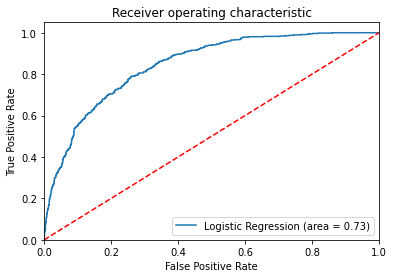

In [72]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg_resam.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg_resam.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## 4. Improve Model

In [73]:
def evaluate_model(cv):
  # get the model
  model = LogisticRegression(solver = 'liblinear',max_iter=100)
  # evaluate the model
  scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
  # return scores
  return mean(scores), scores.min(), scores.max()

folds = range(2,31)
for k in folds:
    # define the test condition
    cv = KFold(n_splits=k, shuffle=True, random_state=10)
    # record mean and min/max of each set of results
    k_mean, k_min, k_max = evaluate_model(cv)
    # report performance
    print('-> folds=%d, accuracy=%.3f (%.3f,%.3f)' % (k, k_mean, k_min, k_max))

-> folds=2, accuracy=0.810 (0.800,0.819)
-> folds=3, accuracy=0.813 (0.797,0.823)
-> folds=4, accuracy=0.810 (0.794,0.822)
-> folds=5, accuracy=0.809 (0.797,0.817)
-> folds=6, accuracy=0.810 (0.794,0.823)
-> folds=7, accuracy=0.810 (0.793,0.822)
-> folds=8, accuracy=0.811 (0.787,0.835)
-> folds=9, accuracy=0.811 (0.797,0.823)
-> folds=10, accuracy=0.809 (0.790,0.824)
-> folds=11, accuracy=0.810 (0.784,0.831)
-> folds=12, accuracy=0.810 (0.776,0.831)
-> folds=13, accuracy=0.809 (0.780,0.843)
-> folds=14, accuracy=0.809 (0.775,0.841)
-> folds=15, accuracy=0.810 (0.772,0.842)
-> folds=16, accuracy=0.810 (0.773,0.838)
-> folds=17, accuracy=0.810 (0.768,0.855)
-> folds=18, accuracy=0.810 (0.760,0.851)
-> folds=19, accuracy=0.810 (0.760,0.843)
-> folds=20, accuracy=0.810 (0.770,0.846)
-> folds=21, accuracy=0.811 (0.764,0.848)
-> folds=22, accuracy=0.811 (0.778,0.843)
-> folds=23, accuracy=0.810 (0.768,0.853)
-> folds=24, accuracy=0.810 (0.768,0.857)
-> folds=25, accuracy=0.810 (0.745,0.851)


In [74]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
start_time = datetime.now()

#Hyperparameter tuning
# define model/create instance
lr=LogisticRegression(solver = 'liblinear',max_iter=100)

#tuning weight for minority class then weight for majority class will be 1-weight of minority class
#Setting the range for class weights
weights = np.linspace(0.0,0.99,500)

#specifying all hyperparameters with possible values
param= {'C': [0.1, 0.5, 1,10,15,20], 
        'penalty': ['l2'],
        "class_weight":[{0:x ,1:1.0 -x} for x in weights]}

# create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 100)

#Gridsearch for hyperparam tuning
model= GridSearchCV(estimator= lr,
                    param_grid=param, 
                    scoring="f1",
                    cv=folds,return_train_score=True)

#train model to learn relationships between x and y
model.fit(X_train,y_train)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:07:38.857097


In [75]:
# print best hyperparameters
print("Best F1 score: ", model.best_score_)
print("Best hyperparameters: ", model.best_params_)

Best F1 score:  0.653187912742984
Best hyperparameters:  {'C': 15, 'class_weight': {0: 0.3729859719438878, 1: 0.6270140280561123}, 'penalty': 'l2'}


In [76]:
#Building Model again with best params
lr2=LogisticRegression(class_weight={0:0.37,1:0.63},C=15,penalty="l2")
lr2.fit(X_train,y_train)

LogisticRegression(C=15, class_weight={0: 0.37, 1: 0.63})

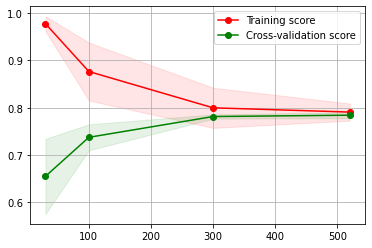

In [77]:
train_sizes, train_scores, test_scores = learning_curve(lr2,X_train, y_train, cv = 3, train_sizes = [1, 30,100,300,520])
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                  train_scores_mean + train_scores_std, alpha=0.1,
                  color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                  test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
          label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
          label="Cross-validation score")

plt.legend(loc="best")

- Learning curve of a good fit model has a moderately high training loss at the beginning which gradually decreases upon adding training examples and flattens gradually, indicating addition of more training examples doesn’t improve the model performance on training data.
- Interpreting the validation loss
     Learning curve of a good fit model has a high validation loss at the beginning which gradually decreases upon adding training examples and flattens gradually, indicating addition of more training examples doesn’t improve the model performance on unseen data.

    We can also see that upon adding a reasonable number of training examples, both the training and validation loss moved close to each other.


- Typical features of the learning curve of a good fit model
1. Training loss and Validation loss are close to each other with validation loss being slightly greater than the training loss.
2. Initially decreasing training and validation loss and a pretty flat training and validation loss after some point till the end.

In [78]:
# Evaluating on Test Set
# predict probabilities on Test and take probability for class 1([:1])
y_pred_prob_test = lr2.predict_proba(X_test)[:, 1]
#predict labels on test dataset
y_pred_test = lr2.predict(X_test)
# create onfusion matrix
cm = confusion_matrix(y_test, y_pred_test)
print("confusion Matrix is :nn",cm)
print("n")
# Accuracy score
print('accuracy score is: ', accuracy_score(y_test,y_pred_test))
# ROC- AUC score
print("ROC-AUC score  test dataset:  t", roc_auc_score(y_test,y_pred_prob_test))
#Precision score
print("precision score  test dataset:  t", precision_score(y_test,y_pred_test))
#Recall Score
print("Recall score  test dataset:  t", recall_score(y_test,y_pred_test))
#f1 score
print("f1 score  test dataset :  t", f1_score(y_test,y_pred_test))
print(classification_report(y_test,y_pred_test))

confusion Matrix is :nn [[1249  295]
 [ 170  396]]
n
accuracy score is:  0.7796208530805687
ROC-AUC score  test dataset:  t 0.8442929658177556
precision score  test dataset:  t 0.573082489146165
Recall score  test dataset:  t 0.6996466431095406
f1 score  test dataset :  t 0.6300715990453462
              precision    recall  f1-score   support

           0       0.88      0.81      0.84      1544
           1       0.57      0.70      0.63       566

    accuracy                           0.78      2110
   macro avg       0.73      0.75      0.74      2110
weighted avg       0.80      0.78      0.79      2110



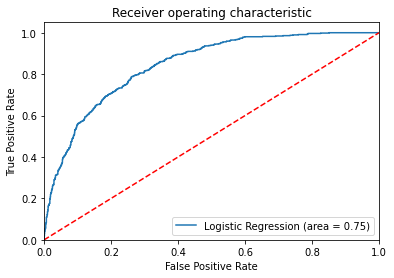

In [79]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
implogit_roc_auc = roc_auc_score(y_test, lr2.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, lr2.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % implogit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## Predict risk of customer churn

### sampling customer for prediction

In [80]:
X_test.columns

RangeIndex(start=0, stop=46, step=1)

#### customer no.3

In [81]:
dummy_df_logis.iloc[3,1:]

Tenure Months                                 28.00
Monthly Charges                              104.80
Total Charges                               3046.05
Gender_Female                                  1.00
Gender_Male                                    0.00
Senior Citizen_No                              1.00
Senior Citizen_Yes                             0.00
Partner_No                                     0.00
Partner_Yes                                    1.00
Dependents_No                                  0.00
Dependents_Yes                                 1.00
Phone Service_No                               0.00
Phone Service_Yes                              1.00
Multiple Lines_No                              0.00
Multiple Lines_No phone service                0.00
Multiple Lines_Yes                             1.00
Internet Service_DSL                           0.00
Internet Service_Fiber optic                   1.00
Internet Service_No                            0.00
Online Secur

In [82]:
# no.3 of customer
print("actual churn is ",dummy_df_logis.iloc[3,0])
p = list(dummy_df_logis.iloc[3,1:])
p = pd.DataFrame(data=p)
p = p.T
p[:5]

actual churn is  1


,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
0,28.0,104.8,3046.05,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [83]:
output = lr2.predict(p)
print('predict churn is ', output[0])

predict churn is  1


#### customer no.7014 

In [84]:
dummy_df_logis.iloc[7014,1:]

Tenure Months                                12.0
Monthly Charges                              19.2
Total Charges                               239.0
Gender_Female                                 0.0
Gender_Male                                   1.0
Senior Citizen_No                             1.0
Senior Citizen_Yes                            0.0
Partner_No                                    0.0
Partner_Yes                                   1.0
Dependents_No                                 0.0
Dependents_Yes                                1.0
Phone Service_No                              0.0
Phone Service_Yes                             1.0
Multiple Lines_No                             1.0
Multiple Lines_No phone service               0.0
Multiple Lines_Yes                            0.0
Internet Service_DSL                          0.0
Internet Service_Fiber optic                  0.0
Internet Service_No                           1.0
Online Security_No                            0.0


In [85]:
# customer no.7014
print("actual churn is ",dummy_df_logis.iloc[7014,0]) #change no here
p = list(dummy_df_logis.iloc[7014,1:]) #change no here
p = pd.DataFrame(data=p)
p = p.T
output = lr2.predict(p)
print('predict churn is ', output[0])

actual churn is  0
predict churn is  1


#### customer no.555 

In [86]:
dummy_df_logis.iloc[555,1:]

Tenure Months                                 17.00
Monthly Charges                               80.85
Total Charges                               1400.85
Gender_Female                                  0.00
Gender_Male                                    1.00
Senior Citizen_No                              1.00
Senior Citizen_Yes                             0.00
Partner_No                                     0.00
Partner_Yes                                    1.00
Dependents_No                                  1.00
Dependents_Yes                                 0.00
Phone Service_No                               0.00
Phone Service_Yes                              1.00
Multiple Lines_No                              1.00
Multiple Lines_No phone service                0.00
Multiple Lines_Yes                             0.00
Internet Service_DSL                           0.00
Internet Service_Fiber optic                   1.00
Internet Service_No                            0.00
Online Secur

In [87]:
# customer no.555 
print("actual churn is ",dummy_df_logis.iloc[555,0]) #change no here
p = list(dummy_df_logis.iloc[555,1:]) #change no here
p = pd.DataFrame(data=p)
p = p.T
output = lr2.predict(p)
print('predict churn is ', output[0])

actual churn is  1
predict churn is  1


#### customer no.678 

In [104]:
dummy_df_logis.iloc[6524,1:]

Tenure Months                                1.00
Monthly Charges                             20.25
Total Charges                               20.25
Gender_Female                                0.00
Gender_Male                                  1.00
Senior Citizen_No                            1.00
Senior Citizen_Yes                           0.00
Partner_No                                   1.00
Partner_Yes                                  0.00
Dependents_No                                1.00
Dependents_Yes                               0.00
Phone Service_No                             0.00
Phone Service_Yes                            1.00
Multiple Lines_No                            1.00
Multiple Lines_No phone service              0.00
Multiple Lines_Yes                           0.00
Internet Service_DSL                         0.00
Internet Service_Fiber optic                 0.00
Internet Service_No                          1.00
Online Security_No                           0.00


In [105]:
# customer no.678 
print("actual churn is ",dummy_df_logis.iloc[6524,0]) #change no here
p = list(dummy_df_logis.iloc[6524,1:]) #change no here
p = pd.DataFrame(data=p)
p = p.T
output = lr2.predict(p)
print('predict churn is ', output[0])

actual churn is  0
predict churn is  0


### Example 4 customers, 3 out of 4 is correct.

# --------------------------------------------------------------------------------------------

# Logistic Regression (Reduced Model)

In [106]:
from sklearn.feature_selection import RFE

## 1. Prepare Data for Logistic Regression

In [107]:
df_logis_red = df[['Churn Value','Gender','Senior Citizen','Partner','Dependents','Tenure Months','Phone Service','Multiple Lines','Internet Service','Online Security','Online Backup','Device Protection','Tech Support','Streaming TV','Streaming Movies','Contract','Paperless Billing','Payment Method','Monthly Charges','Total Charges']]
df_logis_red.head()

,Churn Value,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges
0,1,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15
1,1,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65
2,1,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50
3,1,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05
4,1,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30


In [108]:
dummy_logis_red = pd.get_dummies(df_logis_red)
dummy_logis_red.head()

,Churn Value,Tenure Months,Monthly Charges,Total Charges,Gender_Female,Gender_Male,Senior Citizen_No,Senior Citizen_Yes,Partner_No,Partner_Yes,...,Streaming Movies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,Paperless Billing_No,Paperless Billing_Yes,Payment Method_Bank transfer (automatic),Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check
0,1,2,53.85,108.15,0,1,1,0,1,0,...,0,1,0,0,0,1,0,0,0,1
1,1,2,70.70,151.65,1,0,1,0,1,0,...,0,1,0,0,0,1,0,0,1,0
2,1,8,99.65,820.50,1,0,1,0,1,0,...,1,1,0,0,0,1,0,0,1,0
3,1,28,104.80,3046.05,1,0,1,0,0,1,...,1,1,0,0,0,1,0,0,1,0
4,1,49,103.70,5036.30,0,1,1,0,1,0,...,1,1,0,0,0,1,1,0,0,0


In [120]:
y = dummy_logis_red['Churn Value']
X = dummy_logis_red.drop('Churn Value', axis=1)

#normalization
mm = preprocessing.StandardScaler()
X = pd.DataFrame(mm.fit_transform(X))


# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 100)

In [123]:
#Feature selection 
#Recursive feature elimination
from sklearn.feature_selection import RFE

logreg = LogisticRegression(penalty="l2",random_state=100,solver = 'liblinear',max_iter=100)
# logreg = LogisticRegression()
#Select best feature 
rfe = RFE(logreg, n_features_to_select=15)  #ลองเลือกตัวแปรอิสระมา 15 ตัว จาก 48 ตัว Categorical+Continuous Variables
rfe = rfe.fit(X_train, y_train.ravel())


#Summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)
#ตัวแปรอิสระ 15 ตัวที่ถูกเลือก
print(X_train.columns[rfe.support_])


[ True  True  True False False False False  True False  True  True False
 False  True False False False  True False  True False False False False
 False False False False  True False False False False False False False
  True  True False  True False  True False False  True False]
[ 1  1  1 29 32 25 28  1  8  1  1 30 27  1 26 15  4  1  5  1 12 18 24 14
 23 31  3 16  1  7 17 13  9  2 11 10  1  1 22  1  6  1 21 20  1 19]
Int64Index([0, 1, 2, 7, 9, 10, 13, 17, 19, 28, 36, 37, 39, 41, 44], dtype='int64')


In [124]:
df_select_red = dummy_logis_red.iloc[:,1:]
df_select_red = df_select_red.iloc[:,[0, 2, 9, 10, 16, 20, 21, 23, 26, 28, 34, 37, 39, 40, 44]]
cols = df_select_red.columns
cols

Index(['Tenure Months', 'Total Charges', 'Dependents_No', 'Dependents_Yes',
       'Internet Service_DSL', 'Online Security_No internet service',
       'Online Security_Yes', 'Online Backup_No internet service',
       'Device Protection_No internet service', 'Tech Support_No',
       'Streaming Movies_No', 'Contract_Month-to-month', 'Contract_Two year',
       'Paperless Billing_No', 'Payment Method_Electronic check'],
      dtype='object')

In [125]:
# เอาตัวแปรอิสระ 15 ตัวที่ถูกเลือกมาพิจารณาต่อด้วยการดูค่า p-value
y = dummy_logis_red['Churn Value']
X = dummy_logis_red[cols]

# Implementing the model
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.404215
         Iterations 8
                                            Results: Logit
Model:                           Logit                         Pseudo R-squared:              0.302    
Dependent Variable:              Churn Value                   AIC:                           5710.8743
Date:                            2022-05-02 15:37              BIC:                           5800.0312
No. Observations:                7032                          Log-Likelihood:                -2842.4  
Df Model:                        12                            LL-Null:                       -4071.7  
Df Residuals:                    7019                          LLR p-value:                   0.0000   
Converged:                       1.0000                        Scale:                         1.0000   
No. Iterations:                  8.0000                                                                
-------

In [126]:
#ตัดตัวแปรอิสระออก 4 ตัว ได้แก่ 
    #Dependents_No
    #Online Security_No internet service
    #Online Backup_No internet service
    #Device Protection_No internet service
#ที่ไม่มีผลต่อ Churn Value เนื่องจากค่า p-value > 0.05 
#จากนั้นเอาตัวแปรอิสระ 10 ตัวที่เหลือ มาพิจารณาต่อ
df_logis_red2 = dummy_logis_red[['Churn Value','Tenure Months','Total Charges','Dependents_Yes','Internet Service_DSL',
        'Online Security_Yes','Tech Support_No','Streaming Movies_No','Contract_Month-to-month',
        'Contract_Two year','Paperless Billing_No','Payment Method_Electronic check']]
    
y = df_logis_red2['Churn Value']
X = df_logis_red2.drop('Churn Value', axis=1)

import statsmodels.api as sm
logit_model2=sm.Logit(y,X)
result2=logit_model2.fit()
print(result2.summary2())

Optimization terminated successfully.
         Current function value: 0.412308
         Iterations 8
                                 Results: Logit
Model:                    Logit                 Pseudo R-squared:      0.288    
Dependent Variable:       Churn Value           AIC:                   5820.7012
Date:                     2022-05-02 15:37      BIC:                   5896.1417
No. Observations:         7032                  Log-Likelihood:        -2899.4  
Df Model:                 10                    LL-Null:               -4071.7  
Df Residuals:             7021                  LLR p-value:           0.0000   
Converged:                1.0000                Scale:                 1.0000   
No. Iterations:           8.0000                                                
--------------------------------------------------------------------------------
                                 Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------

In [127]:
#ตัดตัวแปรอิสระ'Streaming Movies_No'ออก 1 ตัว ที่ไม่มีผลต่อ Churn Value เนื่องจากค่า p-value > 0.05 
#จากนั้นเอาตัวแปรอิสระ 10 ตัวที่เหลือ มาพิจารณาต่อ
df_logis_red3 = dummy_logis_red[['Churn Value','Tenure Months','Total Charges',
                                 'Dependents_Yes','Internet Service_DSL','Online Security_Yes',
                                 'Tech Support_No','Contract_Month-to-month','Contract_Two year',
                                 'Paperless Billing_No','Payment Method_Electronic check']]

y = df_logis_red3['Churn Value']
X = df_logis_red3.drop('Churn Value', axis=1)

import statsmodels.api as sm
logit_model3=sm.Logit(y,X)
result3=logit_model3.fit()
print(result3.summary2())

Optimization terminated successfully.
         Current function value: 0.412379
         Iterations 8
                                 Results: Logit
Model:                    Logit                 Pseudo R-squared:      0.288    
Dependent Variable:       Churn Value           AIC:                   5819.6967
Date:                     2022-05-02 15:37      BIC:                   5888.2790
No. Observations:         7032                  Log-Likelihood:        -2899.8  
Df Model:                 9                     LL-Null:               -4071.7  
Df Residuals:             7022                  LLR p-value:           0.0000   
Converged:                1.0000                Scale:                 1.0000   
No. Iterations:           8.0000                                                
--------------------------------------------------------------------------------
                                 Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------

## 2. modeling

In [128]:
df_logis_red_ = dummy_logis_red[['Churn Value','Tenure Months','Total Charges',
                                 'Dependents_Yes','Internet Service_DSL','Online Security_Yes',
                                 'Tech Support_No','Contract_Month-to-month','Contract_Two year',
                                 'Paperless Billing_No','Payment Method_Electronic check']]

y = df_logis_red_['Churn Value']
X = df_logis_red_.drop('Churn Value', axis=1)

#normalization
mm = preprocessing.StandardScaler()
X = pd.DataFrame(mm.fit_transform(X))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression(solver = 'liblinear',max_iter=100)
logreg.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

## 3. Evaluate Model

In [130]:
# Predicting the test results and calculating the accuracy
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.79


In [131]:
# Confusion Matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
cnf_matrix


array([[1366,  191],
       [ 247,  306]], dtype=int64)

In [132]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test,y_test)))
print('accuracy score is: ', accuracy_score(y_test,y_pred))
print('roc auc score is: ', roc_auc_score(y_test,y_pred))
print('precision score is: ',precision_score(y_test,y_pred))
print('recall score is: ', recall_score(y_test,y_pred))
print(classification_report(y_test, y_pred))

Accuracy of logistic regression classifier on test set: 0.79
accuracy score is:  0.7924170616113744
roc auc score is:  0.7153367920178485
precision score is:  0.6156941649899397
recall score is:  0.5533453887884268
              precision    recall  f1-score   support

           0       0.85      0.88      0.86      1557
           1       0.62      0.55      0.58       553

    accuracy                           0.79      2110
   macro avg       0.73      0.72      0.72      2110
weighted avg       0.79      0.79      0.79      2110



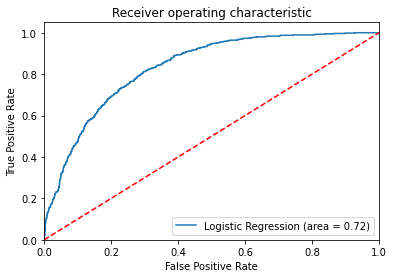

In [133]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
implogit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % implogit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## 4. Improve Model

In [134]:
def evaluate_model(cv):
  # get the model
  model = LogisticRegression(solver = 'liblinear',max_iter=100)
  # evaluate the model
  scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
  # return scores
  return mean(scores), scores.min(), scores.max()

folds = range(2,31)
for k in folds:
    # define the test condition
    cv = KFold(n_splits=k, shuffle=True, random_state=10)
    # record mean and min/max of each set of results
    k_mean, k_min, k_max = evaluate_model(cv)
    # report performance
    print('-> folds=%d, accuracy=%.3f (%.3f,%.3f)' % (k, k_mean, k_min, k_max))

-> folds=2, accuracy=0.805 (0.800,0.811)
-> folds=3, accuracy=0.807 (0.796,0.817)
-> folds=4, accuracy=0.806 (0.788,0.821)
-> folds=5, accuracy=0.805 (0.793,0.820)
-> folds=6, accuracy=0.806 (0.788,0.822)
-> folds=7, accuracy=0.806 (0.789,0.819)
-> folds=8, accuracy=0.806 (0.785,0.826)
-> folds=9, accuracy=0.806 (0.789,0.826)
-> folds=10, accuracy=0.806 (0.790,0.834)
-> folds=11, accuracy=0.806 (0.786,0.831)
-> folds=12, accuracy=0.807 (0.778,0.828)
-> folds=13, accuracy=0.805 (0.778,0.835)
-> folds=14, accuracy=0.806 (0.775,0.835)
-> folds=15, accuracy=0.807 (0.774,0.838)
-> folds=16, accuracy=0.807 (0.777,0.843)
-> folds=17, accuracy=0.806 (0.771,0.847)
-> folds=18, accuracy=0.806 (0.765,0.844)
-> folds=19, accuracy=0.806 (0.765,0.859)
-> folds=20, accuracy=0.806 (0.773,0.838)
-> folds=21, accuracy=0.807 (0.770,0.844)
-> folds=22, accuracy=0.806 (0.775,0.850)
-> folds=23, accuracy=0.806 (0.778,0.852)
-> folds=24, accuracy=0.806 (0.775,0.857)
-> folds=25, accuracy=0.806 (0.755,0.868)


In [135]:
# Model Improvement
#Hyperparameter tuning
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
start_time = datetime.now()

# define model/create instance
lr=LogisticRegression(solver = 'liblinear',max_iter=100)

#tuning weight for minority class then weight for majority class will be 1-weight of minority class
#Setting the range for class weights
weights = np.linspace(0.0,0.99,500)

#specifying all hyperparameters with possible values
param= {'C': [0.1, 0.5, 1,10,15,20], 
        'penalty': ['l2'],
        "class_weight":[{0:x ,1:1.0 -x} for x in weights]}

# create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 100)

#Gridsearch for hyperparam tuning
model= GridSearchCV(estimator= lr,
                    param_grid=param, 
                    scoring="f1",
                    cv=folds,return_train_score=True)

#train model to learn relationships between x and y
model.fit(X_train,y_train)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:02:29.293391


In [136]:
# print best hyperparameters
print("Best F1 score: ", model.best_score_)
print("Best hyperparameters: ", model.best_params_)

Best F1 score:  0.6537583348564808
Best hyperparameters:  {'C': 0.5, 'class_weight': {0: 0.38092184368737475, 1: 0.6190781563126253}, 'penalty': 'l2'}


In [137]:
#Building Model again with best params
lr3=LogisticRegression(class_weight={0:0.38,1:0.62},C=0.5,penalty="l2")
lr3.fit(X_train,y_train)

LogisticRegression(C=0.5, class_weight={0: 0.38, 1: 0.62})

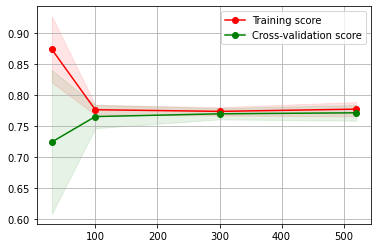

In [138]:
# re-evaluate
train_sizes, train_scores, test_scores = learning_curve(lr3,X_train, y_train, cv = 5, train_sizes = [1, 30,100,300,520])
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                  train_scores_mean + train_scores_std, alpha=0.1,
                  color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                  test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
          label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
          label="Cross-validation score")

plt.legend(loc="best")

In [139]:
# predict probabilities on Test and take probability for class 1([:1])
y_pred_prob_test = lr3.predict_proba(X_test)[:, 1]
#predict labels on test dataset
y_pred_test = lr3.predict(X_test)
# create onfusion matrix
cm = confusion_matrix(y_test, y_pred_test)
print("confusion Matrix is :nn",cm)
print("n")
# Accuracy score
print('accuracy score is: ', accuracy_score(y_test,y_pred_test))
# ROC- AUC score
print("ROC-AUC score  test dataset:  t", roc_auc_score(y_test,y_pred_prob_test))
#Precision score
print("precision score  test dataset:  t", precision_score(y_test,y_pred_test))
#Recall Score
print("Recall score  test dataset:  t", recall_score(y_test,y_pred_test))
#f1 score
print("f1 score  test dataset :  t", f1_score(y_test,y_pred_test))

confusion Matrix is :nn [[1237  320]
 [ 165  388]]
n
accuracy score is:  0.7701421800947867
ROC-AUC score  test dataset:  t 0.8333670142772359
precision score  test dataset:  t 0.5480225988700564
Recall score  test dataset:  t 0.701627486437613
f1 score  test dataset :  t 0.6153846153846153


In [140]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.88      0.79      0.84      1557
           1       0.55      0.70      0.62       553

    accuracy                           0.77      2110
   macro avg       0.72      0.75      0.73      2110
weighted avg       0.79      0.77      0.78      2110



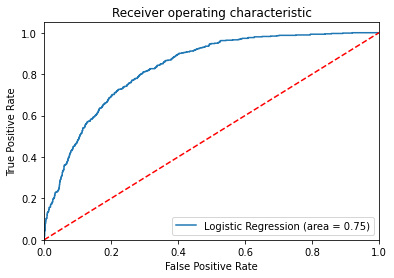

In [141]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
implogit_roc_auc = roc_auc_score(y_test, lr3.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, lr3.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % implogit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## Predict risk of customer churn

### sampling customer for prediction

In [142]:
pd.options.display.max_columns = None
dummy_df_logis

,Churn Value,Tenure Months,Monthly Charges,Total Charges,Gender_Female,Gender_Male,Senior Citizen_No,Senior Citizen_Yes,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,Phone Service_No,Phone Service_Yes,Multiple Lines_No,Multiple Lines_No phone service,Multiple Lines_Yes,Internet Service_DSL,Internet Service_Fiber optic,Internet Service_No,Online Security_No,Online Security_No internet service,Online Security_Yes,Online Backup_No,Online Backup_No internet service,Online Backup_Yes,Device Protection_No,Device Protection_No internet service,Device Protection_Yes,Tech Support_No,Tech Support_No internet service,Tech Support_Yes,Streaming TV_No,Streaming TV_No internet service,Streaming TV_Yes,Streaming Movies_No,Streaming Movies_No internet service,Streaming Movies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,Paperless Billing_No,Paperless Billing_Yes,Payment Method_Bank transfer (automatic),Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check
0,1,2,53.85,108.15,0,1,1,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1
1,1,2,70.70,151.65,1,0,1,0,1,0,0,1,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
2,1,8,99.65,820.50,1,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,1,0
3,1,28,104.80,3046.05,1,0,1,0,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,1,0
4,1,49,103.70,5036.30,0,1,1,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,72,21.15,1419.40,1,0,1,0,1,0,1,0,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,1,0,0,0
7039,0,24,84.80,1990.50,0,1,1,0,0,1,0,1,0,1,0,0,1,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1
7040,0,72,103.20,7362.90,1,0,1,0,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0
7041,0,11,29.60,346.45,1,0,1,0,0,1,0,1,1,0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0


### customer no.3

In [143]:
dummy_df_logis.iloc[3,[1,3,11,17,22,29,38,40,41,45]]

Tenure Months                        28.00
Total Charges                      3046.05
Dependents_Yes                        1.00
Internet Service_DSL                  0.00
Online Security_Yes                   0.00
Tech Support_No                       0.00
Contract_Month-to-month               1.00
Contract_Two year                     0.00
Paperless Billing_No                  0.00
Payment Method_Electronic check       1.00
Name: 3, dtype: float64

In [144]:
print("actual churn is ",dummy_df_logis.iloc[3,0])
p = list(dummy_df_logis.iloc[3,[1,3,11,17,22,29,38,40,41,45]])
p = pd.DataFrame(data=p)
p = p.T
output = lr3.predict(p)
print('predict churn is ', output[0])

actual churn is  1
predict churn is  1


### customer no.7014

In [145]:
dummy_df_logis.iloc[7014,[1,3,11,17,22,29,38,40,41,45]]

Tenure Months                       12.0
Total Charges                      239.0
Dependents_Yes                       1.0
Internet Service_DSL                 0.0
Online Security_Yes                  0.0
Tech Support_No                      0.0
Contract_Month-to-month              1.0
Contract_Two year                    0.0
Paperless Billing_No                 0.0
Payment Method_Electronic check      1.0
Name: 7025, dtype: float64

In [146]:
print("actual churn is ",dummy_df_logis.iloc[7014,0])
p = list(dummy_df_logis.iloc[7014,[1,3,11,17,22,29,38,40,41,45]])
p = pd.DataFrame(data=p)
p = p.T
output = lr3.predict(p)
print('predict churn is ', output[0])

actual churn is  0
predict churn is  1


### customer no.555

In [147]:
dummy_df_logis.iloc[555,[1,3,11,17,22,29,38,40,41,45]]

Tenure Months                        17.00
Total Charges                      1400.85
Dependents_Yes                        0.00
Internet Service_DSL                  0.00
Online Security_Yes                   0.00
Tech Support_No                       1.00
Contract_Month-to-month               1.00
Contract_Two year                     0.00
Paperless Billing_No                  1.00
Payment Method_Electronic check       1.00
Name: 555, dtype: float64

In [148]:
print("actual churn is ",dummy_df_logis.iloc[555,0])
p = list(dummy_df_logis.iloc[555,[1,3,11,17,22,29,38,40,41,45]])
p = pd.DataFrame(data=p)
p = p.T
output = lr3.predict(p)
print('predict churn is ', output[0])

actual churn is  1
predict churn is  1


### customer no.678

In [149]:
dummy_df_logis.iloc[6524,[1,3,11,17,22,29,38,40,41,45]]

Tenure Months                       1.00
Total Charges                      20.25
Dependents_Yes                      0.00
Internet Service_DSL                0.00
Online Security_Yes                 0.00
Tech Support_No                     0.00
Contract_Month-to-month             1.00
Contract_Two year                   0.00
Paperless Billing_No                0.00
Payment Method_Electronic check     0.00
Name: 6533, dtype: float64

In [150]:
print("actual churn is ",dummy_df_logis.iloc[6524,0])
p = list(dummy_df_logis.iloc[6524,[1,3,11,17,22,29,38,40,41,45]])
p = pd.DataFrame(data=p)
p = p.T
output = lr3.predict(p)
print('predict churn is ', output[0])

actual churn is  0
predict churn is  1


### Example 4 customers, 3 out of 4 is correct.

# --------------------------------------------------------------------------------------------